In [6]:
import numpy as np 
import pickle
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# get residuals
avg_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-avg.p"
avg_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-avg.p"

max_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-max.p"
max_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-max.p"

min_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-min.p"
min_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-min.p"

last_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-last.p"
last_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-last.p"

# open files
avg_residual_layer1 = pickle.load( open( avg_residual_file_layer1, "rb" ) )
avg_residual_layer2 = pickle.load( open( avg_residual_file_layer2, "rb" ) )

max_residual_layer1 = pickle.load( open( max_residual_file_layer1, "rb" ) )
max_residual_layer2 = pickle.load( open( max_residual_file_layer2, "rb" ) )

min_residual_layer1 = pickle.load( open( min_residual_file_layer1, "rb" ) )
min_residual_layer2 = pickle.load( open( min_residual_file_layer2, "rb" ) )

last_residual_layer1 = pickle.load( open( last_residual_file_layer1, "rb" ) )
last_residual_layer2 = pickle.load( open( last_residual_file_layer2, "rb" ) )

In [8]:
def clean_roi(roi_vals, roi_labels):
    roi_vals = roi_vals.reshape((len(roi_vals), ))
    final_roi_labels = []
    for val_index in roi_vals:
        if val_index == 0:
            final_roi_labels.append("other")
        else:
            final_roi_labels.append(roi_labels[val_index-1][0][0])
    return final_roi_labels

def clean_atlas(atlas_vals, atlas_labels):
    at_vals = atlas_vals.reshape((len(atlas_vals), ))
    at_labels = []
    for val_index in at_vals:
        at_labels.append(atlas_labels[val_index-1][0][0])
    return at_labels

In [9]:
# get atlas and roi
atlas_vals = pickle.load( open( "atlas_vals.p", "rb" ) )
atlas_labels = pickle.load( open( "atlas_labels.p", "rb" ) )
roi_vals = pickle.load( open( "roi_vals.p", "rb" ) )
roi_labels = pickle.load( open( "roi_labels.p", "rb" ) )

final_roi_labels = clean_roi(roi_vals, roi_labels)
at_labels = clean_atlas(atlas_vals, atlas_labels)

In [10]:
# get activations
activations = pickle.load( open( "activations.p", "rb" ) )
modified_activations = pickle.load( open( "modified_activations.p", "rb" ) )

In [11]:
df_dict = {'voxel_index': list(range(len(at_labels))) * 8, 
            'residuals': avg_residual_layer1 + avg_residual_layer2 + max_residual_layer1 + max_residual_layer2 + min_residual_layer1 + min_residual_layer2 + last_residual_layer1 + last_residual_layer2, 
            'atlas_labels': at_labels * 8, 
            'roi_labels': final_roi_labels * 8,
            'agg_type': ['avg']*len(at_labels)*2 + ['max']*len(at_labels)*2 + ['min']*len(at_labels)*2 + ['last']*len(at_labels)*2,
            'layer': (['layer1']*len(at_labels) + ['layer2']*len(at_labels))*4 }

df = pd.DataFrame(df_dict)

In [12]:
df.head()

,agg_type,atlas_labels,layer,residuals,roi_labels,voxel_index
0,avg,Cerebelum_8_L,layer1,5.530148e-12,other,0
1,avg,Cerebelum_7b_L,layer1,5.547563e-12,other,1
2,avg,Cerebelum_8_R,layer1,5.181878e-12,other,2
3,avg,Cerebelum_8_L,layer1,5.271514e-12,other,3
4,avg,Cerebelum_8_L,layer1,5.446057e-12,other,4


In [13]:
pickle.dump( df, open( "subj1-2layer-4aggs.p", "wb" ) )

In [14]:
df.to_csv("subj1-2layer-4aggs.csv")

### Prepping for Permutation Testing

In [15]:
only_avg_layer1 = df[df['agg_type'] == 'avg'][df['layer'] == 'layer1']

/Users/christinejou/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [16]:
def get_shuffle(df):
    original = df[['atlas_labels','residuals']]
    permutate_values = original["residuals"].sample(frac=1)
    permutate = pd.DataFrame({'atlas_labels': original["atlas_labels"], 'residuals':list(permutate_values)})
    return original, permutate

In [17]:
def calculate_p_value(df1, df2):
    numerator = 0
    df1_values = list(df1["residuals"])
    df2_values = list(df2["residuals"])
    for i in range(len(df1_values)):
        if df1_values[i] < df2_values[i]:
            numerator += 1
    return numerator * 1.0 / len(df1_values)

In [18]:
p_values = []
for _ in tqdm(range(1000)):
    original, permutate = get_shuffle(only_avg_layer1)
    p_val = calculate_p_value(permutate, original)
    p_values.append(p_val)

100%|██████████| 1000/1000 [01:21<00:00, 11.94it/s]


In [19]:
p_values

[0.49995702394097075,
 0.5001487632812551,
 0.49981817821179925,
 0.5004793483507111,
 0.500307444114594,
 0.4997123909895734,
 0.5000892579687531,
 0.4996264388715148,
 0.49981817821179925,
 0.49959999206595834,
 0.5004132313368199,
 0.49881981130204234,
 0.5003471143229287,
 0.49974544949651895,
 0.4992627952951133,
 0.5001685983854225,
 0.5000033058506945,
 0.5002611622048702,
 0.4992627952951133,
 0.5004264547395981,
 0.5010744014757318,
 0.5010413429687861,
 0.5009024972396147,
 0.4995603218576236,
 0.4992694069965024,
 0.5008694387326691,
 0.49997024734374895,
 0.5002876090104267,
 0.4997917314062428,
 0.4993685825173392,
 0.49975206119790805,
 0.49893221022565737,
 0.500082646267364,
 0.5007305930034975,
 0.49995702394097075,
 0.49924296019094594,
 0.49914378467010917,
 0.4998710718229122,
 0.5011934121007359,
 0.5002347153993137,
 0.4992231250867786,
 0.4995867686631801,
 0.5004264547395981,
 0.5014314333507441,
 0.49983140161457745,
 0.499302465503448,
 0.4985553432464776,
 0.

### Checking for certain brain region

In [20]:
original_cerebelum = original[original["atlas_labels"] == "Cerebelum_8_L"]
permutate_cerebelum = permutate[permutate["atlas_labels"] == "Cerebelum_8_L"]

In [21]:
calculate_p_value(original_cerebelum, permutate_cerebelum)

0.9754098360655737

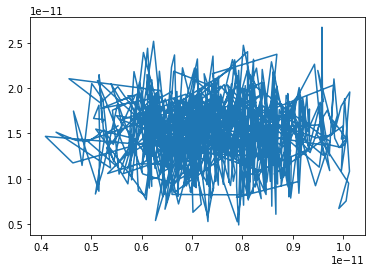

In [22]:
plt.plot(original_cerebelum["residuals"], permutate_cerebelum["residuals"])
plt.show()

In [23]:
original_cerebelum.head()

,atlas_labels,residuals
0,Cerebelum_8_L,5.530148e-12
3,Cerebelum_8_L,5.271514e-12
4,Cerebelum_8_L,5.446057e-12
5,Cerebelum_8_L,5.606933e-12
6,Cerebelum_8_L,5.526162e-12


In [24]:
permutate_cerebelum.head()

,atlas_labels,residuals
0,Cerebelum_8_L,1.584178e-11
3,Cerebelum_8_L,1.491613e-11
4,Cerebelum_8_L,1.189917e-11
5,Cerebelum_8_L,1.578639e-11
6,Cerebelum_8_L,1.829186e-11


### General Brain Areas

Original

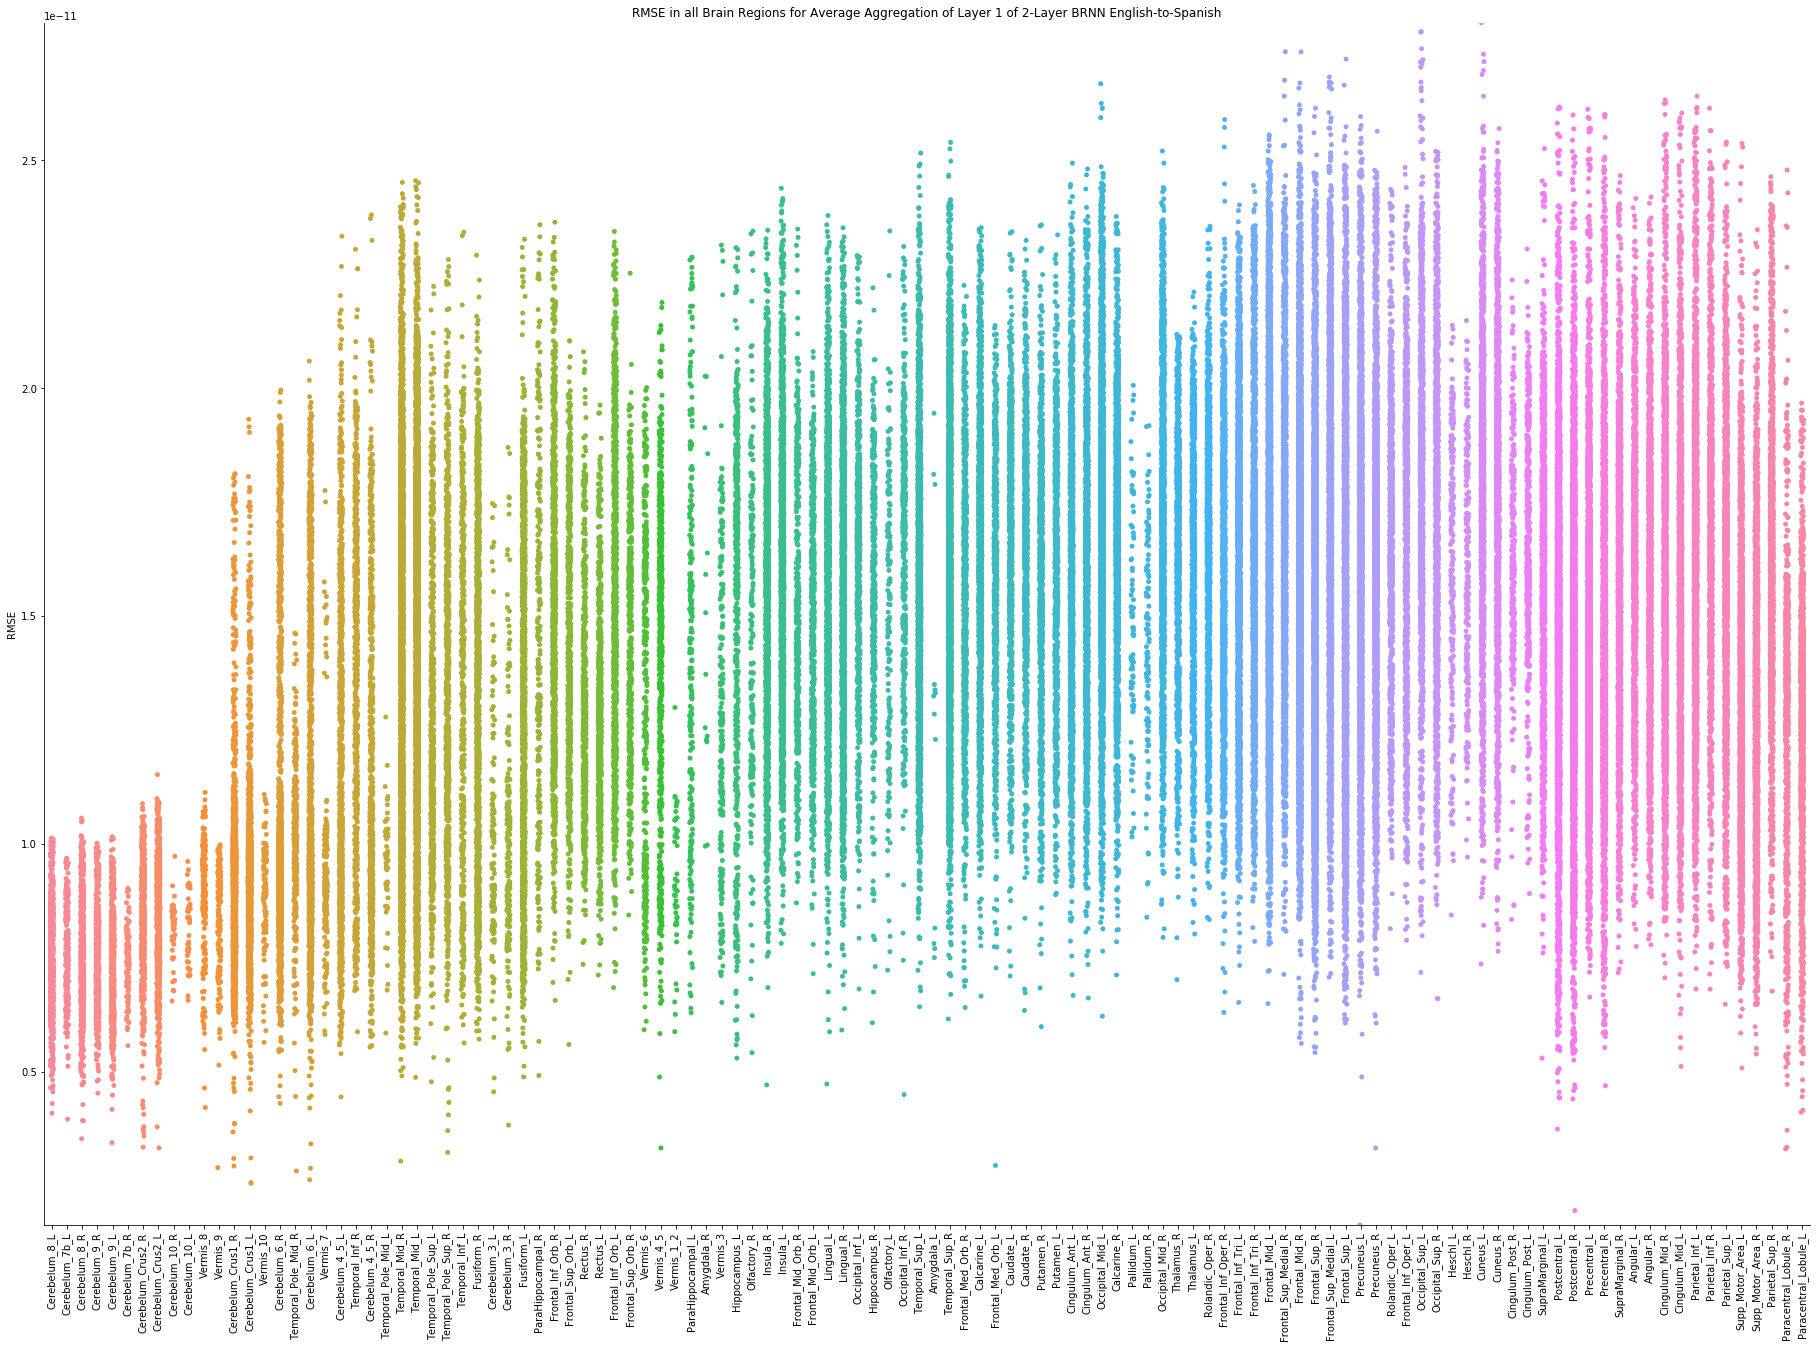

In [25]:
g = sns.catplot(x="atlas_labels", y="residuals", data=original, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(min(original["residuals"]), max(original["residuals"])))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Brain Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish")
plt.show()

Scrambled

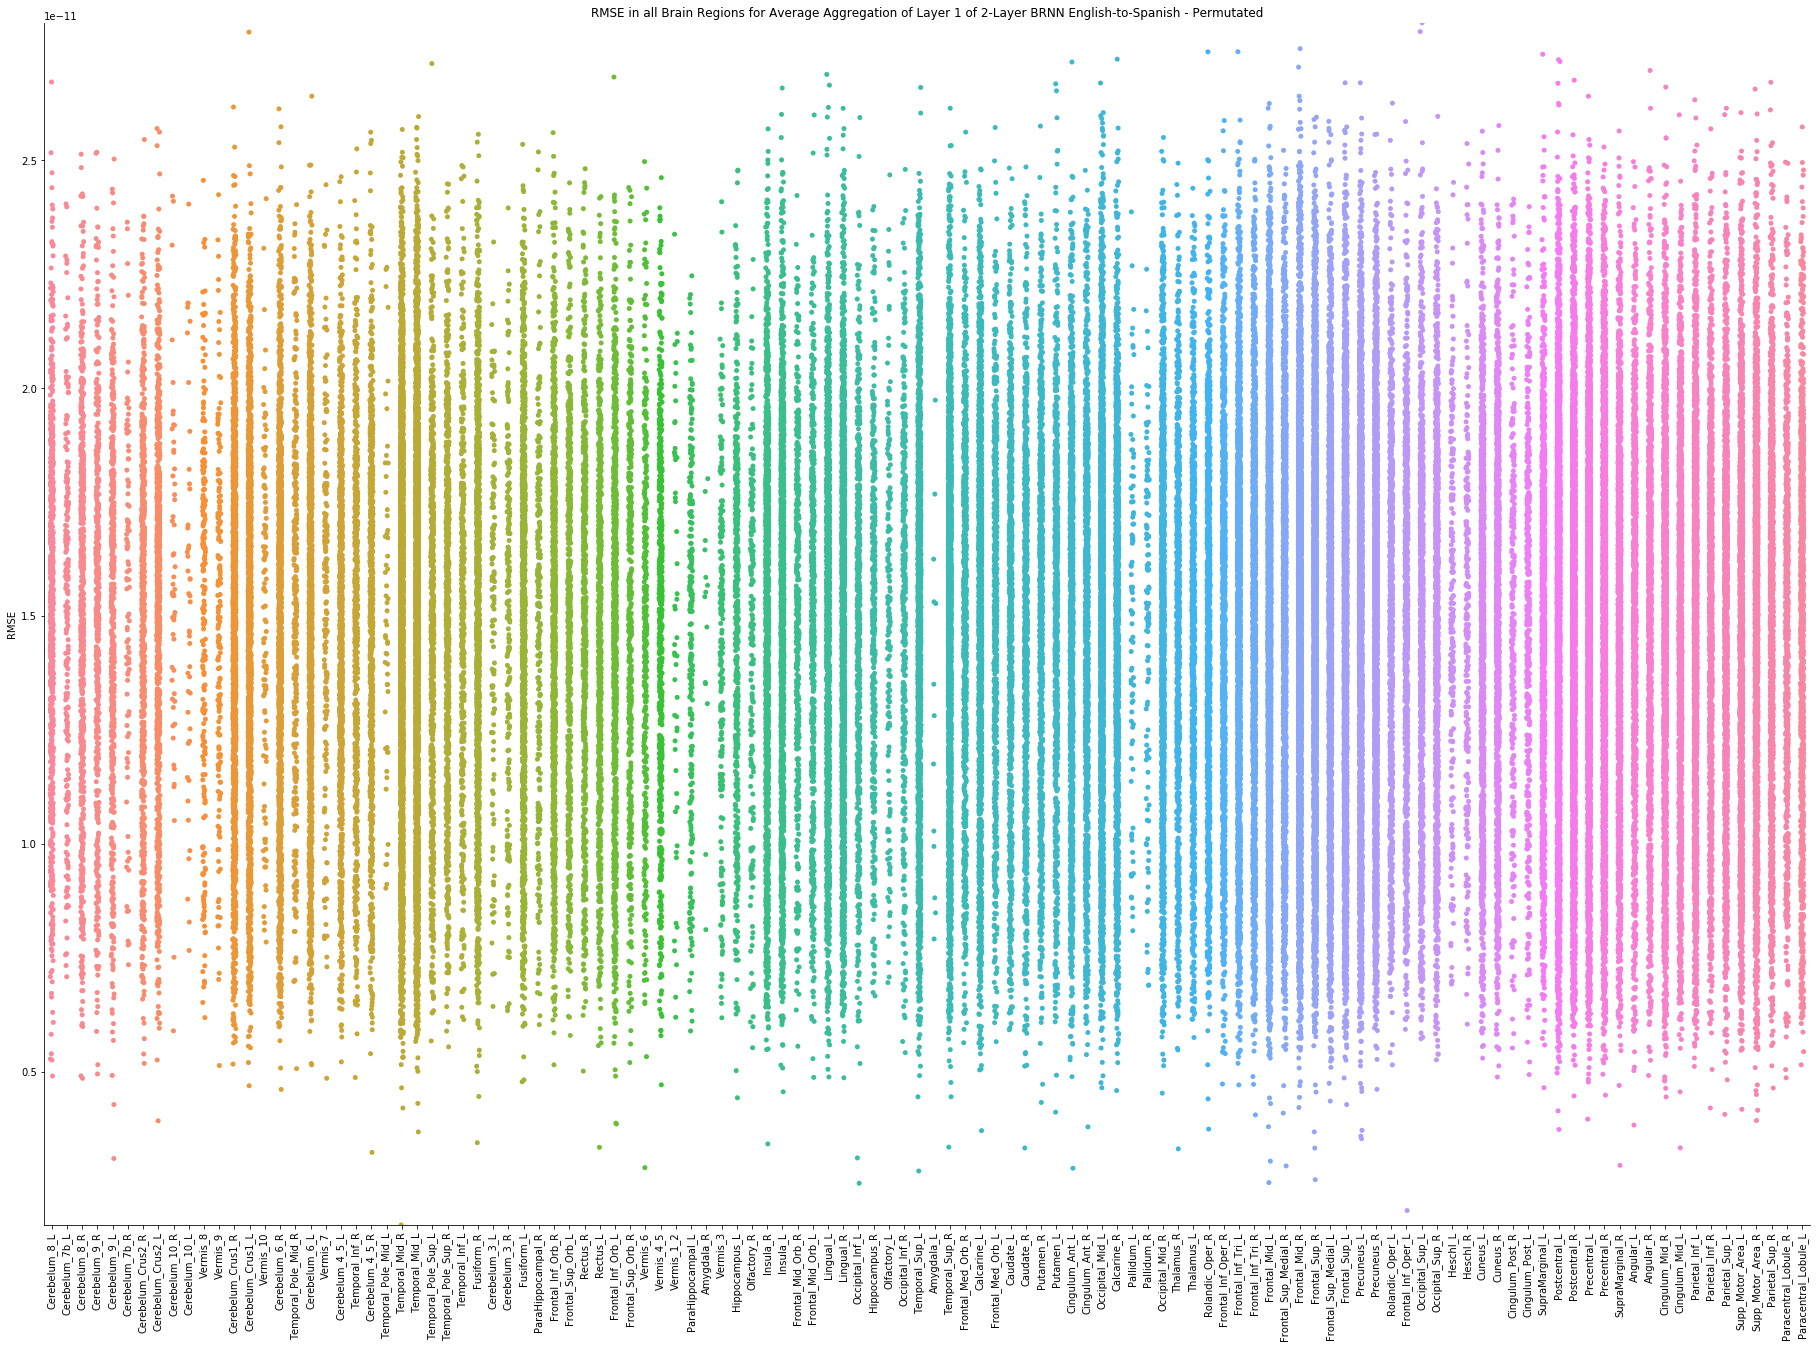

In [26]:
g = sns.catplot(x="atlas_labels", y="residuals", data=permutate, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(min(permutate["residuals"]), max(permutate["residuals"])))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Brain Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish - Permutated")
plt.show()

In [27]:
all_atlas_labels = list(set(list(original["atlas_labels"])))

In [28]:
all_atlas_labels

['Heschl_R',
 'Cerebelum_7b_L',
 'Occipital_Sup_R',
 'Precentral_L',
 'Cerebelum_Crus1_R',
 'Temporal_Mid_R',
 'Frontal_Sup_L',
 'Vermis_7',
 'Vermis_10',
 'Temporal_Sup_L',
 'Parietal_Inf_L',
 'Caudate_L',
 'Precentral_R',
 'Temporal_Pole_Sup_L',
 'Olfactory_L',
 'Cingulum_Mid_R',
 'Paracentral_Lobule_L',
 'Supp_Motor_Area_L',
 'Precuneus_L',
 'Putamen_L',
 'Temporal_Pole_Sup_R',
 'Vermis_1_2',
 'Temporal_Mid_L',
 'Frontal_Inf_Tri_L',
 'Occipital_Sup_L',
 'Amygdala_L',
 'Amygdala_R',
 'Cerebelum_3_L',
 'Rectus_L',
 'Frontal_Mid_Orb_R',
 'Rolandic_Oper_L',
 'Postcentral_L',
 'SupraMarginal_R',
 'Vermis_6',
 'Cerebelum_6_L',
 'SupraMarginal_L',
 'Precuneus_R',
 'Frontal_Inf_Tri_R',
 'Vermis_4_5',
 'Temporal_Inf_L',
 'Heschl_L',
 'Cerebelum_8_R',
 'Olfactory_R',
 'Cerebelum_4_5_R',
 'Lingual_R',
 'Vermis_8',
 'Thalamus_L',
 'Frontal_Med_Orb_R',
 'Occipital_Inf_L',
 'Parietal_Sup_L',
 'Fusiform_R',
 'Cerebelum_Crus2_L',
 'Supp_Motor_Area_R',
 'Cerebelum_6_R',
 'Frontal_Inf_Orb_L',
 'Tempo

In [29]:
len(all_atlas_labels)

116

In [30]:
# p_values = []
# for _ in tqdm(range(200)):
#     original, permutate = get_shuffle(only_avg_layer1)
#     for atlas in all_atlas_labels:
#         original_sub = original[original['atlas_labels'] == atlas]
#         permutate_sub = permutate[permutate['atlas_labels'] == atlas]
#         p_val = calculate_p_value(permutate, original)
#         p_values.append(p_val)

In [31]:
p_values = {}
for _ in tqdm(range(200)):
    original, permutate = get_shuffle(only_avg_layer1)
    for atlas in all_atlas_labels:
        original_sub = original[original['atlas_labels'] == atlas]
        permutate_sub = permutate[permutate['atlas_labels'] == atlas]
        p_val = calculate_p_value(permutate_sub, original_sub)
        if atlas not in p_values:
            p_values[atlas]=[p_val]
        else:
            p_values[atlas].append(p_val)

100%|██████████| 200/200 [13:49<00:00,  3.85s/it]


In [32]:
p_value_and_region = pd.DataFrame.from_dict(p_values)

In [33]:
len(p_values['Amygdala_L'])

200

In [34]:
len(p_values['Frontal_Inf_Orb_L'])

200

In [35]:
p_value_and_region.T.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Amygdala_L,0.384615,0.307692,0.307692,0.384615,0.461538,0.461538,0.461538,0.461538,0.384615,0.461538,...,0.384615,0.307692,0.384615,0.076923,0.384615,0.307692,0.307692,0.384615,0.307692,0.230769
Amygdala_R,0.428571,0.428571,0.500000,0.500000,0.500000,0.642857,0.500000,0.500000,0.428571,0.357143,...,0.642857,0.500000,0.571429,0.500000,0.285714,0.428571,0.357143,0.428571,0.357143,0.500000
Angular_L,0.594128,0.591537,0.585492,0.600173,0.601036,0.594991,0.589810,0.563040,0.595855,0.594128,...,0.601900,0.606218,0.586356,0.582038,0.596718,0.593264,0.580311,0.576857,0.570812,0.582902
Angular_R,0.589508,0.573115,0.587541,0.584918,0.575082,0.546885,0.567213,0.567869,0.569180,0.582295,...,0.560000,0.575082,0.569836,0.572459,0.573115,0.581639,0.568525,0.587541,0.575738,0.575738
Calcarine_L,0.623840,0.634587,0.628725,0.624817,0.615535,0.619932,0.615046,0.627259,0.626771,0.630679,...,0.612115,0.616023,0.622374,0.617978,0.635564,0.630191,0.636053,0.629702,0.636053,0.617978


In [36]:
unstacked_df = pd.DataFrame(p_value_and_region.T.unstack().reset_index())

In [37]:
unstacked_df.head()

,level_0,level_1,0
0,0,Amygdala_L,0.384615
1,0,Amygdala_R,0.428571
2,0,Angular_L,0.594128
3,0,Angular_R,0.589508
4,0,Calcarine_L,0.623840


In [38]:
unstack_p = {'trial': unstacked_df["level_0"], 
            'atlas': unstacked_df["level_1"], 
            'p_value': unstacked_df[0]
}

unstack_p_df = pd.DataFrame(unstack_p)

In [39]:
unstack_p_df.head()

,atlas,p_value,trial
0,Amygdala_L,0.384615,0
1,Amygdala_R,0.428571,0
2,Angular_L,0.594128,0
3,Angular_R,0.589508,0
4,Calcarine_L,0.623840,0


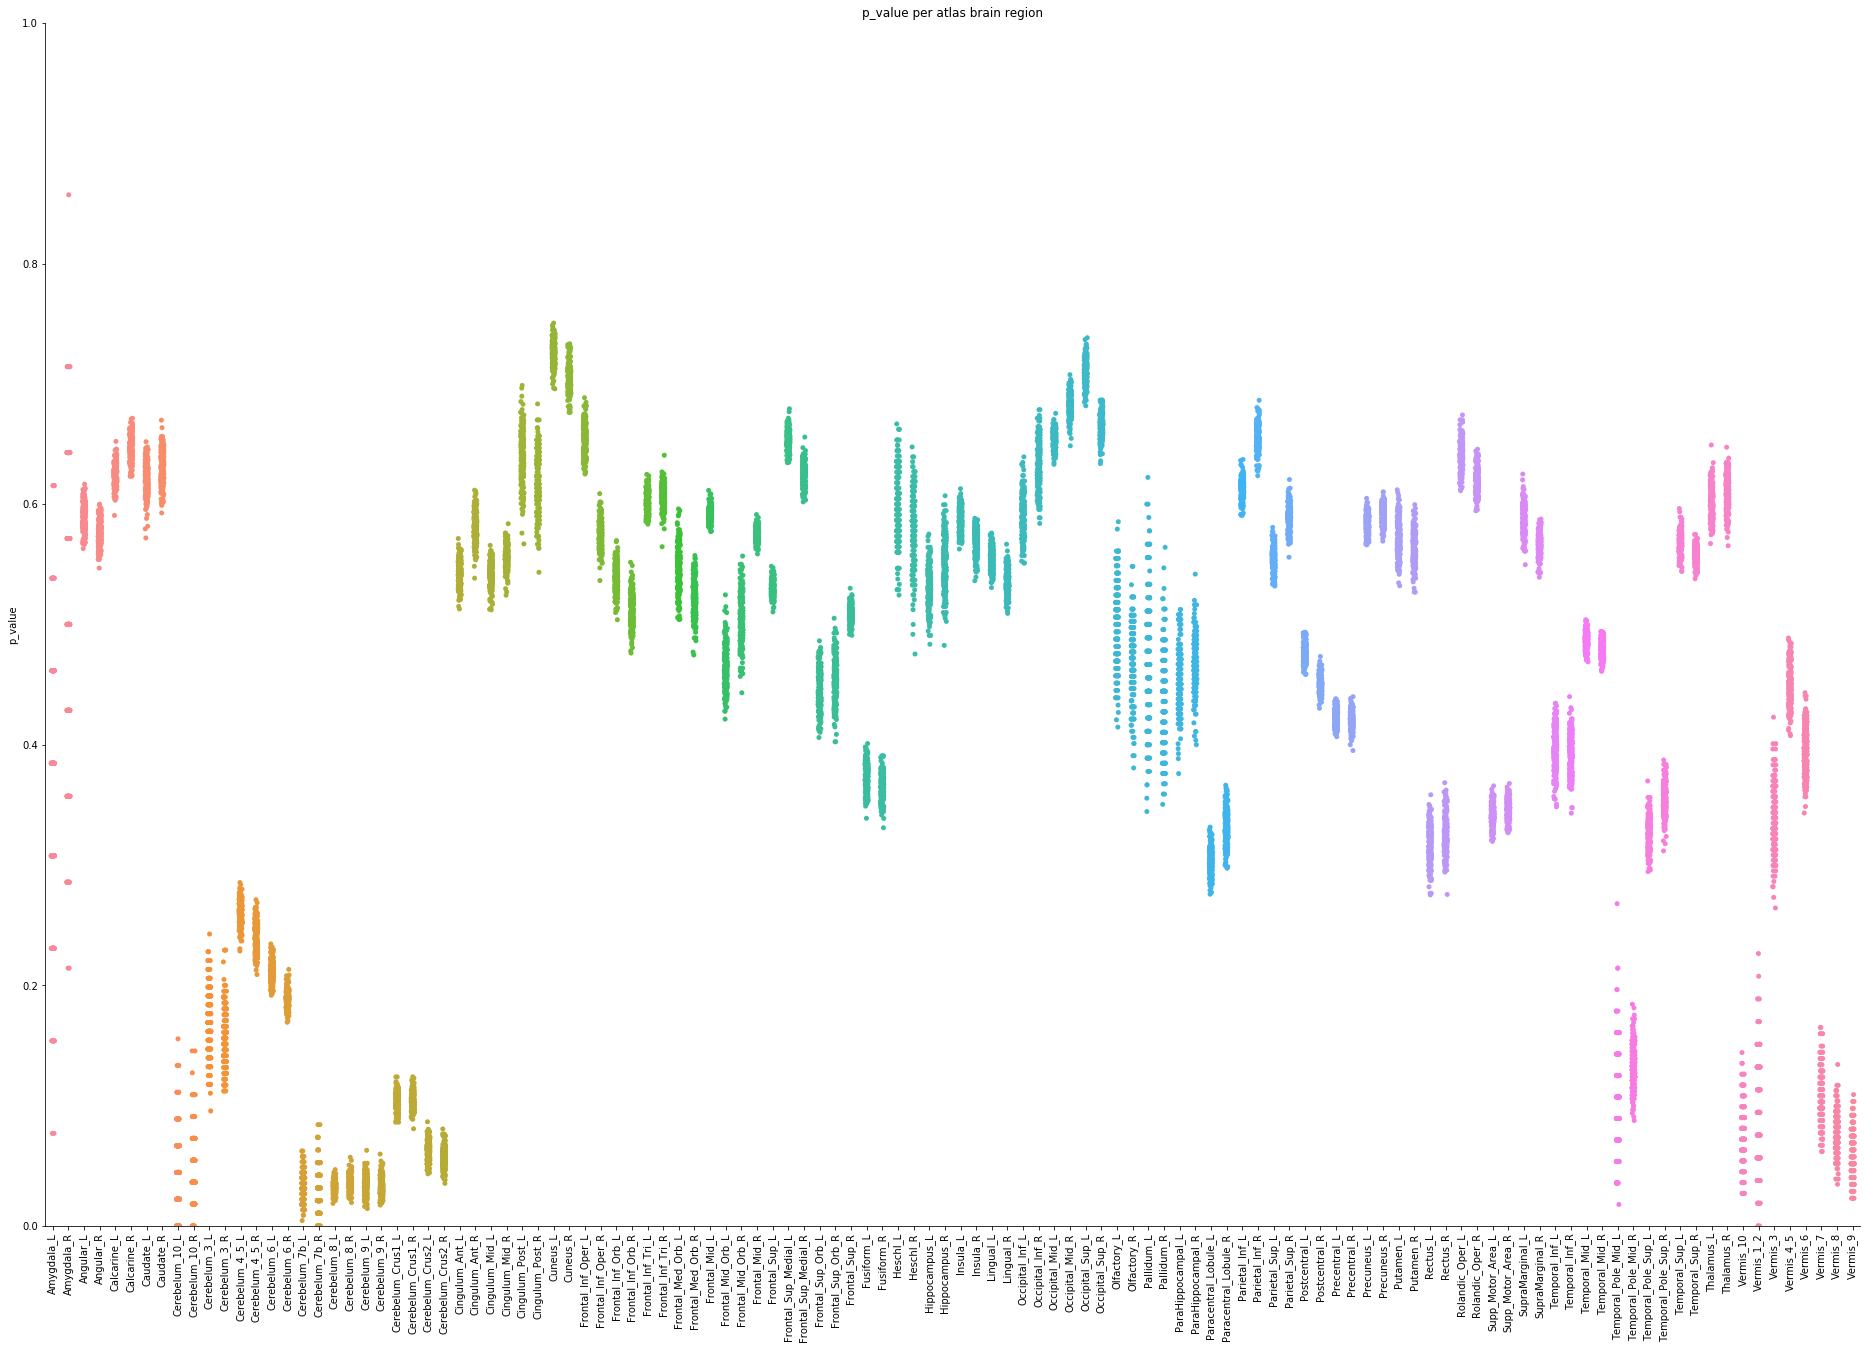

In [40]:
g = sns.catplot(x="atlas", y="p_value", data=unstack_p_df, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(0, 1))
g.set_axis_labels("", "p_value")
plt.title("p_value per atlas brain region")
plt.show()

In [41]:
set(list(final_roi_labels))

{'LAngG',
 'LAntTemp',
 'LIFG',
 'LIFGorb',
 'LMFG',
 'LMidAntTemp',
 'LMidPostTemp',
 'LPostTemp',
 'other'}